# CHAPTER 10 Working with Data

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import scipy.stats
from collections import Counter

In [2]:
import os.path
import sys
from functools import partial

In [3]:
book_dir = '/Users/CBare/Documents/projects/data-science-from-scratch'
sys.path.extend(os.path.join(book_dir, 'chapter_{:02d}'.format(i)) for i in [3,4,5,6,7,8])

In [94]:
from stats import *
from vector import vector_sum, vector_subtract, scalar_multiply, magnitude
from matrix import make_matrix, get_column, shape, matrix_multiply
from gradient_descent import maximize_batch

## Histograms

In [5]:
def bucketize(point, bucket_size):
    """floor the point to the next lower multiple of bucket_size"""
    return bucket_size * math.floor(point / bucket_size)

In [6]:
def make_histogram(points, bucket_size):
    """buckets the points and counts how many in each bucket"""
    return Counter(bucketize(point, bucket_size) for point in points)

In [7]:
def plot_histogram(points, bucket_size, title=""):
    histogram = make_histogram(points, bucket_size)
    plt.bar(histogram.keys(), histogram.values(), width=bucket_size)
    plt.title(title)
    plt.show()

In [8]:
data = np.random.randn(10000)

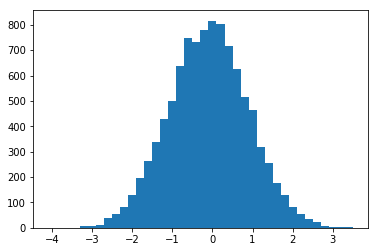

In [9]:
plot_histogram(data, 0.2)

In [10]:
n = 1000
xs = np.random.randn(n)

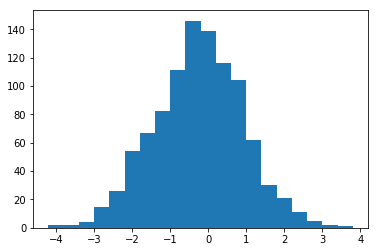

In [11]:
ys1 = xs + np.random.randn(n)/2
plot_histogram(ys1, 0.4)

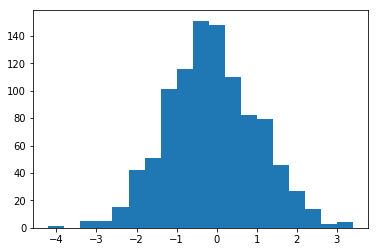

In [12]:
ys2 = -xs + np.random.randn(n)/2
plot_histogram(ys2, 0.4)

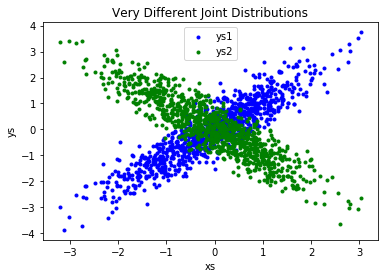

In [13]:
plt.scatter(xs, ys1, marker='.', color='blue', label='ys1')
plt.scatter(xs, ys2, marker='.', color='green',  label='ys2')
plt.xlabel('xs')
plt.ylabel('ys')
plt.legend(loc=9)
plt.title("Very Different Joint Distributions")
plt.show()

## Correlation

In [14]:
correlation(xs, ys1)

0.9080997019822428

In [15]:
correlation(xs, ys2)

-0.8942424606903341

In [16]:
def correlation_matrix(data):
    """
    returns the num_columns x num_columns matrix whose (i, j)th
    entry is the correlation between columns i and j of data
    """
    _, num_columns = shape(data)
    
    def matrix_entry(i, j):
        return correlation(get_column(data, i), get_column(data, j))
    
    return make_matrix(num_columns, num_columns, matrix_entry)

In [17]:
n = 1000
m = 20
data = np.random.randn(n,m)

In [18]:
A = np.array(correlation_matrix(data))

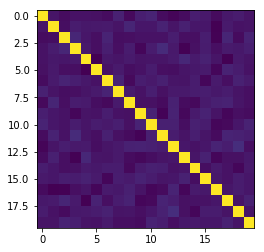

In [19]:
plt.imshow(A)
plt.show()

### Create a matrix with randomly correlated columns

In [20]:
n = 1000
m = 20

In [21]:
means = [0] * m

In [22]:
A = np.array(scipy.stats.uniform().rvs(m*m)).reshape(m,m)
cov = A.T @ A
cov = cov-cov.min()
cov = cov/cov.max()
for i in range(m):
    cov[i,i] = 1.0

In [23]:
M = np.random.multivariate_normal(means, cov, n)

In [24]:
cor_matrix = np.array(correlation_matrix(M))

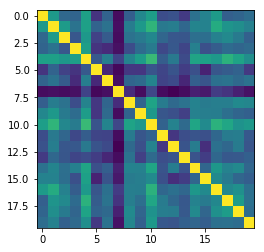

In [25]:
plt.imshow(cor_matrix)
plt.show()

In [26]:
correlation(M[:,12], M[:,19])

0.26428609205874154

# Rescaling

In [27]:
def scale(data):
    num_rows, num_cols = shape(data)
    means = [mean(get_column(data, j)) for j in range(num_cols)]
    stdevs = [standard_deviation(get_column(data, j)) for j in range(num_cols)]
    return means, stdevs

In [28]:
def rescale(data):
    """
    rescales the input data so that each column has mean 0 and standard deviation 1
    leaves alone columns with no deviation
    """
    means, stdevs = scale(data)
    
    def rescaled(i, j):
        if stdevs[j] > 0:
            return (data[i][j] - means[j]) / stdevs[j]
        else:
            return data[i][j]

    num_rows, num_cols = shape(data)
    return make_matrix(num_rows, num_cols, rescaled)

In [29]:
n = 1000
letters = 'abcdefghijklmnopqrstuvwxyz'
params = list(zip(np.random.rand(10), np.random.rand(10)))

data = pd.DataFrame({letter:np.random.normal(mu, sigma, n)
                     for letter, (mu, sigma) in zip(letters, params)})

In [30]:
params

[(0.7779819842140354, 0.3184330457517479),
 (0.45266842080953584, 0.22214383342115118),
 (0.44049427805844155, 0.11483928484797734),
 (0.8795624639737526, 0.6057783636555497),
 (0.4710399535891483, 0.487869057238262),
 (0.192013673474435, 0.07252199707341889),
 (0.4528610225028069, 0.880292050861715),
 (0.6863292681917048, 0.34151304120485704),
 (0.36807182647361114, 0.007961338210035751),
 (0.5020927690490521, 0.630531065197708)]

In [31]:
data.mean()

a    0.779029
b    0.469686
c    0.443048
d    0.874831
e    0.454399
f    0.193261
g    0.478022
h    0.695156
i    0.368189
j    0.524797
dtype: float64

In [32]:
def df_to_list(data):
    return [row.values.tolist() for i,row in data.iterrows()]

In [33]:
data = df_to_list(data)
shape(data)

(1000, 10)

In [34]:
scaled_data = rescale(data)

Check that means are close to zero and SDs are close to 1.

In [35]:
means, sds = scale(scaled_data)
assert all(abs(m - 0)<1e-12 for m in means)
assert all(abs(sd - 1)<1e-12 for sd in sds)

## Dimensionality reduction

In [36]:
def demean_matrix(A):
    """
    returns the result of subtracting from every value in A the mean value of its
    column. the resulting matrix has mean 0 in every column
    """
    nr, nc = shape(A)
    column_means, _ = scale(A)
    return make_matrix(nr, nc, lambda i, j: A[i][j] - column_means[j])

In [37]:
n = 100
A = [[x,y] for x,y in zip(np.random.randn(n) * 10, np.random.randn(n) * 3)]

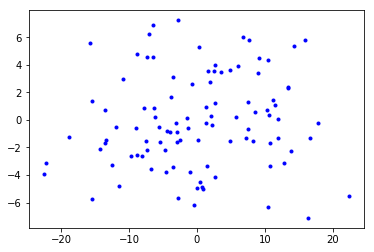

In [38]:
plt.scatter(get_column(A,0), get_column(A,1), marker='.', color='blue')
plt.show()

In [39]:
theta = - math.pi / 7
rotate = [[math.cos(theta), -math.sin(theta)],
          [math.sin(theta), math.cos(theta)]]

In [40]:
B = matrix_multiply(A, rotate)

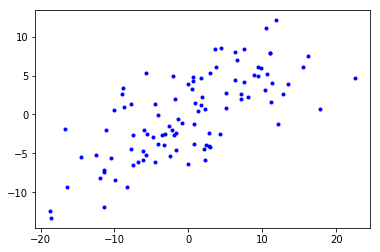

In [41]:
plt.scatter(get_column(B,0), get_column(B,1), marker='.', color='blue')
plt.show()

In [42]:
correlation(get_column(B,0), get_column(B,1))

0.715003792388243

In [43]:
def direction(w):
    mag = magnitude(w)
    return [w_i / mag for w_i in w]

In [44]:
def directional_variance_i(x_i, w):
    """the variance of the row x_i in the direction determined by w"""
    return dot(x_i, direction(w)) ** 2

In [45]:
def directional_variance(X, w):
    """the variance of the data in the direction determined w"""
    return sum(directional_variance_i(x_i, w) for x_i in X)

In [46]:
def directional_variance_gradient_i(x_i, w):
    """the contribution of row x_i to the gradient of the direction-w variance"""
    projection_length = dot(x_i, direction(w))
    return [2 * projection_length * x_ij for x_ij in x_i]

In [47]:
def directional_variance_gradient(X, w):
    return vector_sum(directional_variance_gradient_i(x_i,w) for x_i in X)

In [52]:
def first_principal_component(X):
    guess = [1 for _ in X[0]]
    unscaled_maximizer, values = maximize_batch(
        partial(directional_variance, X), # is now a function of w
        partial(directional_variance_gradient, X), # is now a function of w
        guess)
    return direction(unscaled_maximizer)

In [55]:
pc1 = first_principal_component(B)
pc1

[0.8829115386618349, 0.4695393645880942]

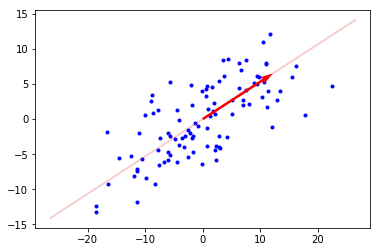

In [89]:
plt.scatter(get_column(B,0), get_column(B,1), marker='.', color='blue')
x = [pc1[0]*i for i in [-30, 1, 30]]
y = [pc1[1]*i for i in [-30, 1, 30]]
plt.plot(x, y, color="#cc000030", linewidth=2)
plt.quiver(pc1[0], pc1[1], angles='xy', scale=4, color='red')
plt.show()

In [90]:
def project(v, w):
    """return the projection of v onto the direction w"""
    projection_length = dot(v, w)
    return scalar_multiply(projection_length, w)

In [91]:
def remove_projection_from_vector(v, w):
    """projects v onto w and subtracts the result from v"""
    return vector_subtract(v, project(v, w))

In [92]:
def remove_projection(X, w):
    """
    for each row of X projects the row onto w, and subtracts the
    result from the row
    """
    return [remove_projection_from_vector(x_i, w) for x_i in X]

In [95]:
C = remove_projection(B, pc1)

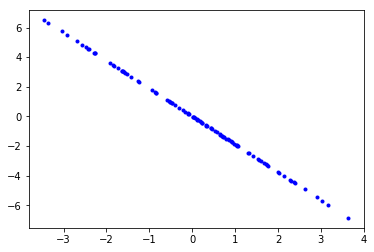

In [96]:
plt.scatter(get_column(C,0), get_column(C,1), marker='.', color='blue')
plt.show()

In [98]:
def principal_components(X, num_components):
    components = []
    for _ in range(num_components):
        component = first_principal_component(X)
        components.append(component)
        X = remove_projection(X, component)
    return components

In [99]:
pcs = principal_components(B, 2)

In [100]:
pcs

[[0.8829115386618349, 0.4695393645880942],
 [-0.4695212684894382, 0.8829211620728483]]

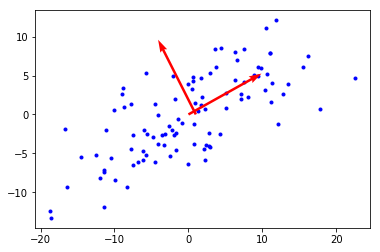

In [101]:
plt.scatter(get_column(B,0), get_column(B,1), marker='.', color='blue')
plt.quiver(get_column(pcs, 0), get_column(pcs, 1), angles='xy', scale=4, color='red')
plt.show()